In [1]:
import numpy as np
import csv
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Pre Processing

First, the city state and email hash are converted into numbers

In [29]:
### Picking the dataset and converting the city_state and e-mail hash

# df = pd.read_csv('cs760-fcc/scripts/dataset.csv')
# data_array = df.to_numpy()
# city_state_dict = {}

# index = 0
# for i  in df['city_state']:
#     if i not in city_state_dict:
#         city_state_dict[i] = index
#         index += 1

# email_hash_dict = {}
# index = 0
# for i  in df['email_hash']:
#     if i not in email_hash_dict:
#         email_hash_dict[i] = index
#         index += 1

# df['city_state']=df['city_state'].replace(city_state_dict)
# df['email_hash']=df['email_hash'].replace(email_hash_dict)

# df.to_pickle("df_replaced")

# f = open("city_state_dict.pkl","wb")
# pickle.dump(city_state_dict,f)
# f.close()
# f = open("email_hash_dict.pkl","wb")
# pickle.dump(email_hash_dict,f)
# f.close()

Loading the data

In [3]:
df = pd.read_pickle("df_replaced")
with open('city_state_dict.pkl', 'rb') as handle:
    city_state_dict = pickle.load(handle)
    
with open('email_hash_dict.pkl', 'rb') as handle:
    email_hash_dict = pickle.load(handle)

Uncomment to see the proportions of not_commenter = {-1,0,1} -> the data needed to be balanced

In [31]:
# df['not_commenter'].value_counts(normalize=True)

In [32]:
# df['not_commenter'].value_counts(normalize=False)

A commom way to balance the data is to UnderSample it (diminish all the labels to the same amount of samples)

In [6]:
# Undersampling
df0=df.loc[df['not_commenter']==0].sample(n=2043)
df1=df.loc[df['not_commenter']==-1].sample(n=2043)
df2=df.loc[df['not_commenter']==1]
df_orig = df
df = pd.concat([df0,df1,df2])

In [7]:
df['not_commenter'].value_counts(normalize=True)

 1.0    0.333333
-1.0    0.333333
 0.0    0.333333
Name: not_commenter, dtype: float64

Getting the labels

In [8]:
y = df['not_commenter'].to_numpy()
df = df.drop(columns=['not_commenter'])

In [9]:
# df.var().nlargest(22)

Normalizing the data (all datas are converted to values between 0 and 1)

In [33]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df=normalized_df.drop(columns=['submissiontype.co'])
normalized_df=normalized_df.drop(columns=['bounced'])
v = normalized_df.var()

In [11]:
# v

In [12]:
# v.sort_values(ascending=False)

In [13]:
# v.nlargest(25)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

Test all choices of using the High Variance features (use 1 feature to 51 features) and save the number of High Variance that gets the best result

In [15]:
max_score = 0;
best_num_feat = 0;
for num_feat in range(len(df.columns)):
    df_filtered = df[v.nlargest(num_feat+1).index]
    X = df_filtered.to_numpy()
    # X = df.to_numpy()
    # X
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1, random_state=2)
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX, trainy)
    if model.score(testX,testy)>max_score:
        best_num_feat = num_feat
        max_score = model.score(testX,testy)

/u/y/a/yamada/python/ml-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/u/y/a/yamada/python/ml-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [16]:
print("Best results with\n\tBest number of features: %d\n\tBest Score: %.2f"%(best_num_feat+1,max_score))

Best results with
	Best number of features: 10
	Best Score: 0.89


In [17]:
df_filtered = df[v.nlargest(best_num_feat).index]
X = df_filtered.to_numpy()
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1, random_state=2)
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

See the results of the best high variance features with logistic regression

In [18]:
predy = model.predict(testX)
predy.shape

(613,)

In [19]:
print("predy = -1: %d" % sum(predy==-1))
print("predy = 0: %d" % sum(predy==0))
print("predy = 1: %d" % sum(predy==1))

predy = -1: 190
predy = 0: 221
predy = 1: 202


In [20]:
print("testy = -1: %d" % sum(testy==-1))
print("testy = 0: %d" % sum(testy==0))
print("testy = 1: %d" % sum(testy==1))

testy = -1: 192
testy = 0: 220
testy = 1: 201


In [21]:
sum(predy==testy)/testy.shape[0]

0.8384991843393148

Start plotting the ROC curve

In [34]:
from sklearn import metrics

In [23]:
testy = label_binarize(testy, classes=[-1,0, 1])
predy = label_binarize(predy, classes=[-1,0, 1])
n_classes = testy.shape[1]

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], predy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [25]:
fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), predy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

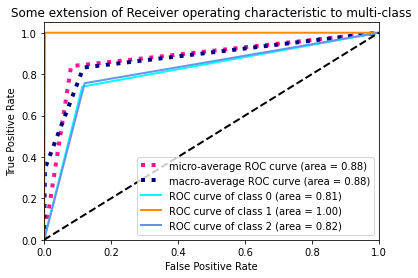

In [26]:
from numpy import interp
from itertools import cycle

lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

See how the model performs using the unbalanced data

In [27]:
df_filtered = df_orig[v.nlargest(best_num_feat).index]
X = df_filtered.to_numpy()
y = df_orig['not_commenter'].to_numpy()
predy = model.predict(X)
print("predy = -1: %d" % sum(predy==-1))
print("predy = 0: %d" % sum(predy==0))
print("predy = 1: %d" % sum(predy==1))
print("testy = -1: %d" % sum(y==-1))
print("testy = 0: %d" % sum(y==0))
print("testy = 1: %d" % sum(y==1))

predy = -1: 8570
predy = 0: 119721
predy = 1: 4237
testy = -1: 10775
testy = 0: 119710
testy = 1: 2043


In [28]:
sum(predy==y)/y.shape[0]

0.9775292768320657

Save the model

In [35]:
pkl_filename = "LogisticRegressionModel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

To load the model

In [36]:
# pkl_filename = "LogisticRegressionModel.pkl"
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)